# Cleanning notebook 

Let's first call the libraries I'll use : 

In [2]:
data_path = "/home/clairegayral/Documents/openclassroom/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split

import itertools as IT

# 1. Import data : 

I have decided to extract the data labeled with the french nutriscore, to set a cleanning method and then decide the application I want to propose. I have in a first place look at a small subset extracted with the website interface, then I downloaded the big data they propose ($10^6$ products). 

- [ ] **Afterwards I would like to fetch from their json API.**

In [3]:
# ## 
# ## SMALL DATA SET (calories > 0)
# ##

# filename = data_path+"openfoodfacts_with_cholesterol.csv"
# df = pd.read_csv(filename,"\t")

In [4]:
##
## THE BIG DATA SET :
##
## lien de telechargement du dataset (3.8 Go): 
## https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv

filename = data_path+"en.openfoodfacts.org.products.csv"

# GET THE NUMBER OF LINES : 
# bash code : cat en.openfoodfacts.org.products.csv | wc -l
# pandas (long to run) : print(pd.read_csv(filename, sep = "\t", usecols = ["code"],dtype = "str", squeeze=True))
with open(filename) as f:
    print("Number of products in the csv :", len(f.readlines())-1)

## GET INDEX OF NUTRI SCORE IN COLUMNS : 
tmp = pd.read_csv(filename, sep = "\t", nrows = 1).columns
col_index = np.where(tmp=="nutrition-score-fr_100g")[0][0]
col_index

## OPEN FILE WITH ITERATOR CHUNKS SELECTING ROWS WITH INFO ON col_index : :
def valid(chunks):
    for chunk in chunks:
        mask = ~chunk.iloc[:,col_index].isna().values
        yield chunk.loc[mask]            
chunksize = 10 ** 4
chunks = pd.read_csv(filename, sep = "\t", low_memory=False, chunksize=chunksize, header=None)
df_original = pd.concat(valid(chunks))
print("Number of variables : ", df_original.shape[1])
print("Number of product selected : ", df_original.shape[0])

Number of products in the csv : 1716277
Number of variables :  184
Number of product selected :  646577


The chunk method does not allow to set header, so let's do it : 

In [5]:
df = df_original.drop(0, axis=0)
df.columns = df_original.loc[0,:]
n = df.shape[0]
df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
4,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,NaN,...,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,Salade de carottes râpées,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is huge ({{df.shape[0]}} products).
Let's first work on a sample of size 10 000, and then comment this part : 

In [6]:
df = df.sample(10000, replace = False)
df.shape

(10000, 184)

## 1.1 Drop Missing values : 
Let's remove the variables with too much NaN. First, I remove the columns filled with NaNs (there is no information in them). 

Then, I have chosen to keep the 1st quantile value of the number of NaNs in each variables : 
* if the variable has less NaNs than this quantile, I will estimate the missing value with KNN procedure, 
* else, I drop the corresponding column. 

In [7]:
##
## TACKLE MISSING VALUES 1 (drop col)
##

## DROP COL FILLED WITH NANs
df = df.loc[:,df.isna().sum(axis=0)<n]
print("There are ", sum(df.isna().sum(axis=0)==n), "variables without any information (all NaNs)")

## DROP COL WITH MORE NANs THAN THE MEAN/1st QUANTILE :
nan_repartition = df.isna().sum(axis=0)
# nan_threshold = nan_repartition.quantile(0.25)
nan_threshold = nan_repartition.mean()
print("I drop variables with more than", nan_threshold, "NaNs")
df = df.drop(df.columns[nan_repartition>nan_threshold], axis = 1)
df.describe()

There are  0 variables without any information (all NaNs)
I drop variables with more than 7243.20652173913 NaNs


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,10000,10000,10000,10000,10000,10000,10000,9976,3838,2873,...,9965.0,5772.0,9965.0,9973.0,9973.0,2827.0,2884.0,3614.0,3515.0,10000.0
unique,10000,10000,601,9924,9923,9866,9865,9394,1086,1447,...,1584.0,281.0,1166.0,1500.0,1468.0,453.0,281.0,391.0,469.0,84.0
top,8801007029658,http://world-en.openfoodfacts.org/product/7613...,kiliweb,1489061945,2017-03-09T12:19:05Z,1587590324,2020-04-22T17:49:24Z,Filet de poulet,200 g,Kunststoff,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,1,1,3818,3,3,3,3,14,176,70,...,1317.0,1746.0,985.0,1120.0,1121.0,1564.0,1786.0,1104.0,1024.0,485.0


## 1.2 Exploration of the different values :

Then, I used the description data in https://world.openfoodfacts.org/data/data-fields.txt, to separate the global data frame into sub-frames. 
Note : to transform the .txt into these lists of variables, I used the bash command : 

    cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_fields2.txt

In [8]:
# USE BASH cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_fields2.txt
list_of_characteristics = ["code","url","creator","created_t","created_datetime","last_modified_t",
                           "last_modified_datetime","product_name","generic_name","quantity"]
list_of_tags = ["packaging", "packaging_tags", "brands", "brands_tags", "categories",
                "categories_tags", "categories_fr","origins", "origins_tags","manufacturing_places",
                "manufacturing_places_tags", "labels", "labels_tags", "labels_fr", "emb_codes", 
                "emb_codes_tags", "first_packaging_code_geo", "cities", "cities_tags", 
                "purchase_places", "stores", "countries", "countries_tags", "countries_fr"]
list_of_ingredients = ["ingredients_text", "traces", "traces_tags"]
list_of_misc = ["serving_size", "no_nutriments", "additives_n", "additives", "additives_tags", 
                "ingredients_from_palm_oil_n", "ingredients_from_palm_oil", 
                "ingredients_from_palm_oil_tags", "ingredients_that_may_be_from_palm_oil_n", 
                "ingredients_that_may_be_from_palm_oil", "ingredients_that_may_be_from_palm_oil_tags", 
                "nutrition_grade_fr", "main_category", "main_category_fr", "image_url", 
                "image_small_url"]
list_of_nutri_facts = ["energy_100g","energy-kj_100g","energy-kcal_100g","proteins_100g","casein_100g",
                       "serum-proteins_100g","nucleotides_100g","carbohydrates_100g","sugars_100g",
                       "sucrose_100g","glucose_100g","fructose_100g","lactose_100g","maltose_100g",
                       "maltodextrins_100g","starch_100g","polyols_100g","fat_100g","saturated-fat_100g",
                       "butyric-acid_100g","caproic-acid_100g","caprylic-acid_100g","capric-acid_100g",
                       "lauric-acid_100g","myristic-acid_100g","palmitic-acid_100g","stearic-acid_100g",
                       "arachidic-acid_100g","behenic-acid_100g","lignoceric-acid_100g","cerotic-acid_100g",
                       "montanic-acid_100g","melissic-acid_100g","monounsaturated-fat_100g",
                       "polyunsaturated-fat_100g","omega-3-fat_100g","alpha-linolenic-acid_100g",
                       "eicosapentaenoic-acid_100g","docosahexaenoic-acid_100g","omega-6-fat_100g",
                       "linoleic-acid_100g","arachidonic-acid_100g","gamma-linolenic-acid_100g",
                       "dihomo-gamma-linolenic-acid_100g","omega-9-fat_100g","oleic-acid_100g",
                       "elaidic-acid_100g","gondoic-acid_100g","mead-acid_100g","erucic-acid_100g",
                       "nervonic-acid_100g","trans-fat_100g","cholesterol_100g","fiber_100g","sodium_100g",
                       "alcohol_100g","vitamin-a_100g","vitamin-d_100g","vitamin-e_100g","vitamin-k_100g",
                       "vitamin-c_100g","vitamin-b1_100g","vitamin-b2_100g","vitamin-pp_100g",
                       "vitamin-b6_100g","vitamin-b9_100g","vitamin-b12_100g","biotin_100g",
                       "pantothenic-acid_100g","silica_100g","bicarbonate_100g","potassium_100g",
                       "chloride_100g","calcium_100g","phosphorus_100g","iron_100g","magnesium_100g",
                       "zinc_100g","copper_100g","manganese_100g","fluoride_100g","selenium_100g",
                       "chromium_100g","molybdenum_100g","iodine_100g","caffeine_100g","taurine_100g",
                       "ph_100g","fruits-vegetables-nuts_100g","carbon-footprint_100g",
                       "nutrition-score-fr_100g","nutrition-score-uk_100g"]

Then I used this partition to explore the data : these category allowed me to have an idea of the values of each variable in one hand and to determine the good type of each variable (set just after). I used the following functionm changing the category of the varibles. To ease the re-utilisation of this code, I commented the different possibilities : 

In [9]:
def print_values_from_list_of_var(df_,list_of_var):
    for var in list_of_var : 
        if var in df_.columns:
            print("--",var)
            tmp = df_[df_.columns.intersection([var])]
            var_values = tmp.iloc[(~pd.isna(tmp).values)]
            if len(var_values) < 8:
                print("values = ", var_values.values)
            else :
                print("ex of values = ", 
                      np.array(tmp.iloc[(~pd.isna(tmp).values)].sample(n=8).values).transpose()[0])
        else : 
            print("--", var, " : no data")
            
# list_of_var = list_of_characteristics
# list_of_var = list_of_tags
# list_of_var = list_of_ingredients
# list_of_var = list_of_misc
list_of_var = list_of_nutri_facts
print_values_from_list_of_var(df,list_of_var)

-- energy_100g
ex of values =  [1255.0 305.0 1220.0 2243.0 1985.0 2092.0 304.0 1837.0]
-- energy-kj_100g  : no data
-- energy-kcal_100g
ex of values =  [467.6 245.0 200.0 294.0 100.0 288.0 391.0 202.0]
-- proteins_100g
ex of values =  [6.6666666666667 7.5 1.0 6.76 8.33 0.0 20.0 2.1]
-- casein_100g  : no data
-- serum-proteins_100g  : no data
-- nucleotides_100g  : no data
-- carbohydrates_100g
ex of values =  [67.0 53.57 82.7 3.8 86.67 5.9 37.2 76.0]
-- sugars_100g
ex of values =  [3.53 6.1 2.9 29.9 38.0 0.0 6.3 56.0]
-- sucrose_100g  : no data
-- glucose_100g  : no data
-- fructose_100g  : no data
-- lactose_100g  : no data
-- maltose_100g  : no data
-- maltodextrins_100g  : no data
-- starch_100g  : no data
-- polyols_100g  : no data
-- fat_100g
ex of values =  [1.5 25.0 0.0 0.0 2.4 0.88 0.5 9.0]
-- saturated-fat_100g
ex of values =  [15.0 0.3 6.0 6.1 0.1 0.0 4.52 1.1]
-- butyric-acid_100g  : no data
-- caproic-acid_100g  : no data
-- caprylic-acid_100g  : no data
-- capric-acid_100g

This variable-type analysis allowed me to select the non-relevant variables for my study, such as the dates. I have keep some variables like the country or the name of the person that put the product in the database, just for the exercice to clean text data. This subset will be call "data" :

In [10]:
interest_var = pd.Index(["code","creator","countries","additives_n","ingredients_from_palm_oil_n",
                "ingredients_that_may_be_from_palm_oil_tags"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))

data = df[df.columns.intersection(interest_var)].copy()
# data = data.fillna(pd.NA)

In [28]:
### GESTION DES TYPES DANS DATA !!
## STR 
str_var = list_of_characteristics 
str_var += list_of_tags
str_var += list_of_ingredients
str_var += list_of_misc
str_var = data.columns.intersection(str_var)
data[str_var] = data[str_var].astype("str")

## FLOATS (and INTs)
float_var = list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_tags"]
float_var = data.columns.intersection(float_var)
data[float_var] = data[float_var].astype("float")

## CATEGORY
data["creator"] = data[["creator","nutrition-score-fr_100g"]].astype("category")
# data.dtypes

Now that the float types are ok, I can call the "describe" method of pandas, to see the summary of the descriptive statistics : 

In [29]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,7240.000000,7240.000000,9347.000000,9965.000000,9965.000000,9965.000000,3511.000000,3558.000000,9961.000000,9965.000000,5772.000000,9965.000000,9973.000000,2827.000000,2884.000000,3614.000000,3515.000000,10000.000000
mean,2.213122,0.019337,282.343514,1172.058048,14.387807,5.400525,0.034842,0.077349,28.761535,13.463554,2.846405,8.528846,0.482202,0.001980,0.022139,0.099759,0.001755,9.281100
std,3.108797,0.137716,192.996710,804.043669,17.671678,8.159627,0.469659,1.969172,27.562831,18.706114,4.292666,8.854721,3.304234,0.077055,0.560333,0.250114,0.003015,8.945126
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000
25%,0.000000,0.000000,110.000000,455.000000,1.100000,0.100000,0.000000,0.000000,4.200000,0.900000,0.000000,2.040000,0.040000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,0.000000,271.000000,1117.000000,8.200000,2.000000,0.000000,0.000000,16.900000,4.100000,1.600000,6.100000,0.240000,0.000000,0.000000,0.038000,0.000960,10.000000
75%,3.000000,0.000000,411.000000,1710.000000,22.700000,7.800000,0.000000,0.021000,53.800000,20.000000,3.600000,12.000000,0.520000,0.000100,0.003425,0.114000,0.002400,16.000000
max,28.000000,1.000000,1682.000000,7037.000000,100.000000,93.330000,20.000000,80.000000,100.000000,100.000000,56.000000,91.000000,220.000000,4.000000,24.000000,10.500000,0.034840,40.000000


## Modification of "ingredients_drom_palm_oil_n" 

This variable was not well documented, my idea is to go back to a simple boolean variable : is there (or not) some ingredients with palm oil ? The issue is that there already exists such a variable. If it is not in my dataset, I create a new variable, if it is, I concat the 2 variables 

I decided to modify some of my variables : 
* if there is no "ingredients_from_palm_oil" but a "ingredients_from_palm_oil_n" colunm, I transformed this one into the first one.


In [30]:
############## dev code ###################
##
## 1st idea of code : 
##

data2 = data.copy()
if "ingredients_from_palm_oil_n" in data2.columns :
    if ~("ingredients_from_palm_oil" in data2.columns) :
        data2.insert(loc = data2.columns.get_loc("ingredients_from_palm_oil_n"),
                    column = "ingredients_from_palm_oil",
                    value = 0)
        index_1 = data2[data2["ingredients_from_palm_oil_n"]==1].index
        data2.at[index_1,"ingredients_from_palm_oil"] = 1
        index_nan = data2[pd.isna(data2["ingredients_from_palm_oil_n"])].index
        data2.at[index_nan,"ingredients_from_palm_oil"] = np.nan
        
    data2.drop("ingredients_from_palm_oil_n", axis=1, inplace = True)
data2.iloc[:,3:10]

## 
## after reflexion, better to do modify directly the line :
##
data2 = data.copy()
if "ingredients_from_palm_oil_n" in data2.columns :
    if ~("ingredients_from_palm_oil" in data2.columns) :
        data2.at[data2["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
        data2.rename(columns={"ingredients_from_palm_oil_n":"ingredients_from_palm_oil"}, inplace=True)

I start to isolate the code I want to re-use to define my prepocess method **(idea : object oriented programmation)**

In [150]:
def preprocess_data(data):
    if "ingredients_from_palm_oil_n" in data.columns :
        data.at[data["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
        if ("ingredients_from_palm_oil" in data.columns) :
            data['ingredients_from_palm_oil'].fillna(data['ingredients_from_palm_oil_n'], inplace=True)
            data.drop("ingredients_from_palm_oil_n", inplace = True, axis = 1)
            print("vlavla")
        else :
            data.rename(columns={"ingredients_from_palm_oil_n":"ingredients_from_palm_oil"}, inplace=True)
            print("vlivli")
# data2 = data.copy()
# data2.at[:,"ingredients_from_palm_oil"] = np.where(data2["nutrition-score-fr_100g"]<0,0,np.nan)
# data2.at[data2["nutrition-score-fr_100g"]>20,"ingredients_from_palm_oil"] = 1
preprocess_data(data)

vlavla


In [147]:
# data2 = data.copy()

# data.at[:,"ingredients_from_palm_oil"] = np.where(data2["nutrition-score-fr_100g"]<0,0,np.nan)
# data.at[data["nutrition-score-fr_100g"]>10,"ingredients_from_palm_oil"] = 1
# data.at[data["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
# data.at[:,"tmp"] = data["ingredients_from_palm_oil"].values

# data2['ingredients_from_palm_oil'].fillna(data['ingredients_from_palm_oil_n'], inplace=True)

In [149]:
data2.loc[:,["code","ingredients_from_palm_oil"]]

,code,ingredients_from_palm_oil
688745,3250390520405,0.0
972336,3760143531089,NaN
1161847,5020000168000,1.0
1607411,8437011986634,NaN
1532610,8421395045636,1.0
...,...,...
186909,71430011393,0.0
652243,3155250364734,1.0
1257924,5604253990191,0.0
435000,856244005123,0.0


In [128]:
data2.loc[:,["code","ingredients_from_palm_oil"]]

,code,ingredients_from_palm_oil
688745,3250390520405,0.0
972336,3760143531089,NaN
1161847,5020000168000,1.0
1607411,8437011986634,NaN
1532610,8421395045636,1.0
...,...,...
652243,3155250364734,NaN
1257924,5604253990191,NaN
435000,856244005123,NaN
250573,88702787115,NaN


# 1.3 Errors in numerical data :

I had so many variables to check ! 
To ease this work, I propose the following procedure :

* 1. graphical reading : to plot the histograms allowed me to pre-select the possible values for each variables. For example, much of the data "_100g" have values above 100, that can not be normal. 
* 2. Put the possible values in a dictonary and ajust it for every variables, to select the outliers or error data. 
* 3. Have a breaf check to be sure that the data I dropped was in deed outliers.


<!-- In the course, they decompose data in 5 classes : 
* lexical errors
* irregularity error
* Formatage error
* Duplicates
* Outliers -->

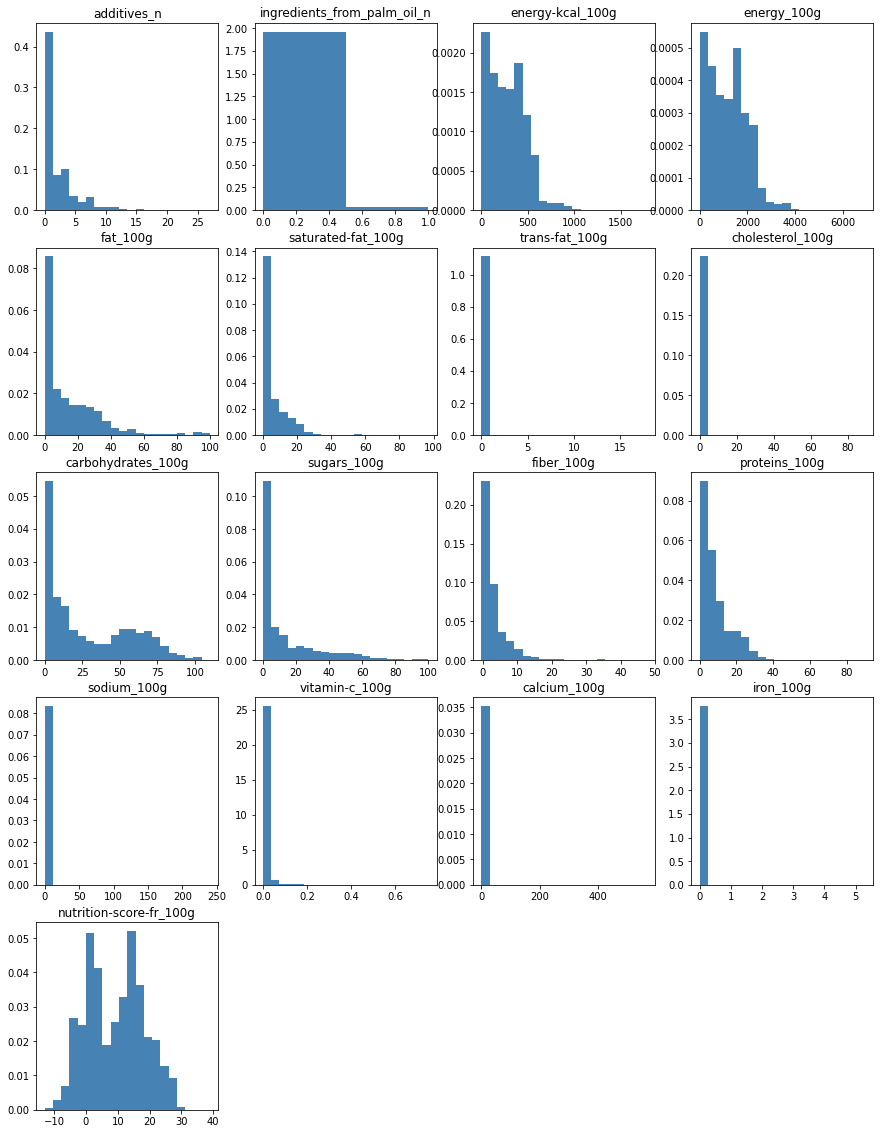

In [12]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count,)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

To ease this manual part, I used the following function, that takes the column name, the possible values we want to set, and returns the values that are not in this set of values :

In [13]:
def extract_irreg_errors_val(colname,possible_values, data = data):
    outliers_val = []
    col_values = data[colname].drop_duplicates().values
    ## check possible values : 
    min_value, max_value = possible_values
    for val in col_values :
        if ~np.isnan(val) :
            if (val < min_value) or (val > max_value):
                outliers_val.append(val)
        else : 
            print(sum(data[colname].isna()),"missing values")
    print(len(outliers_val), "irregular errors")
    return outliers_val

I made a dictionnary of the possible values each variable can take : 

For clarity purposes, I just keep an example of how I proceeded to choose my possible values for each variable :

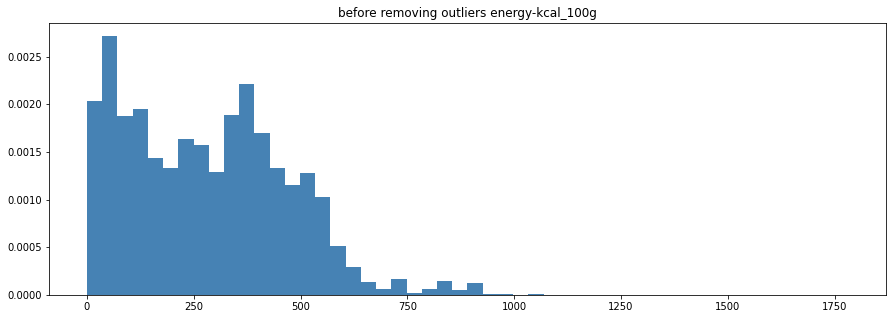

636 missing values
2 irregular errors


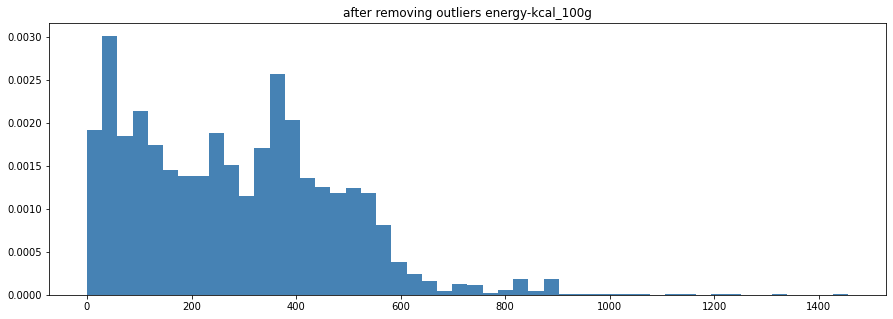

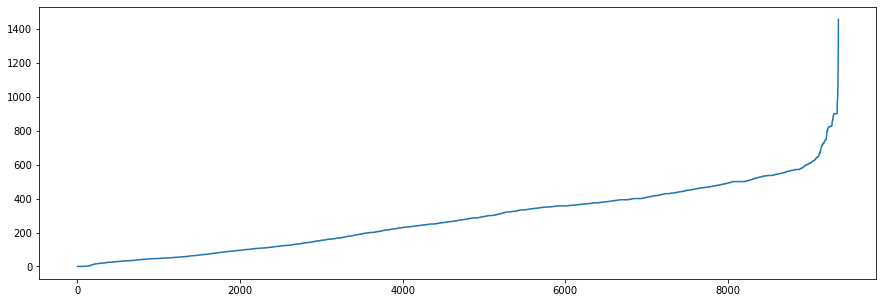

636 missing values
11 irregular errors


array(['Fragata aceitunas negras sin hueso', 'Beef jerky',
       'Rillettes sardines fines herbes bio', 'Fuseau lorrain',
       'Cordons bleus de poulet', 'Farine Pain Blanc', 'Masa para pizza',
       'Ganze Nuss casew und fleur de sel', 'Pâté de campagne Pur Porc'],
      dtype=object)

In [16]:
data2 = data.copy()
colname = "energy-kcal_100g"
possible_values = [0,1500]

## Histogramme global 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("before removing outliers " + colname)
plt.show()

outliers = extract_irreg_errors_val(colname,possible_values, data = data2)
# val_index = data.loc[(data[colname] in outliers),:].index.values
data2.at[data2[colname].isin(outliers)] = np.nan

## Histogramme : 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("after removing outliers " + colname)
plt.show()
# plot values : 
plt.plot(np.sort(data2[colname]))
plt.show()
really_fat = extract_irreg_errors_val(colname, [0,1000], data = data)

np.array(df.loc[data2[colname].isin(really_fat), "product_name"])


In [17]:
possible_val_dict = {'additives_n' : [0,35],'ingredients_from_palm_oil': [0,1],
                     'energy-kcal_100g':[0,1500], 'energy_100g':[0,5000],'fat_100g':[0,100],
                     'saturated-fat_100g': [0,100],'trans-fat_100g':[0,90], 'cholesterol_100g':[0,10],
                     'carbohydrates_100g': [0,100], 'sugars_100g': [0,100], 'fiber_100g': [0,100],
                     'proteins_100g': [0,100],'sodium_100g': [0,100], 'vitamin-a_100g': [0,100],
                     'vitamin-c_100g': [0,1], 'calcium_100g': [0,20],'iron_100g': [0,0.05], 
                     'nutrition-score-fr_100g': [-20,50]}

limit_val_dict = {'additives_n' : [0,30],'ingredients_from_palm_oil': [0,1],
                  'energy-kcal_100g':[0,1000], 'energy_100g':[0,4000],'fat_100g':[0,90],
                  'saturated-fat_100g': [0,40],'trans-fat_100g':[0,2.5], 'cholesterol_100g':[0,0.2],
                  'carbohydrates_100g': [0,95], 'sugars_100g': [0,95], 'fiber_100g': [0,90],
                  'proteins_100g': [0,80],'sodium_100g': [0,10], 'vitamin-a_100g': [0,0.01],
                  'vitamin-c_100g': [0,0.3], 'calcium_100g': [0,10],'iron_100g': [0,0.04], 
                  'nutrition-score-fr_100g': [-15,35]}


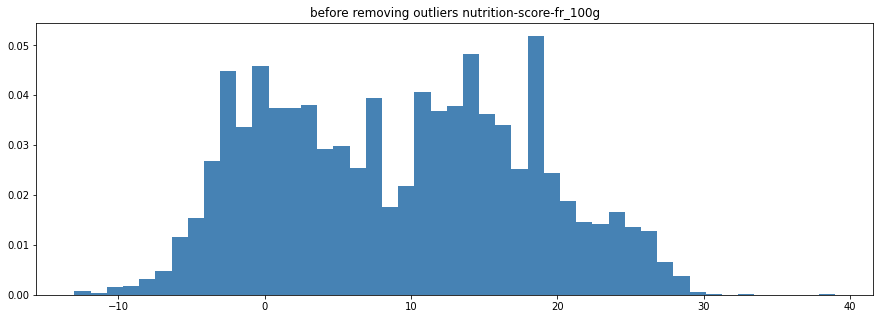

0 irregular errors
outliers products : []


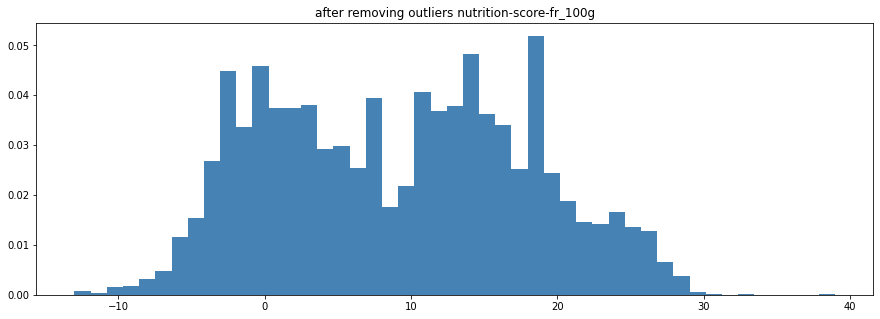

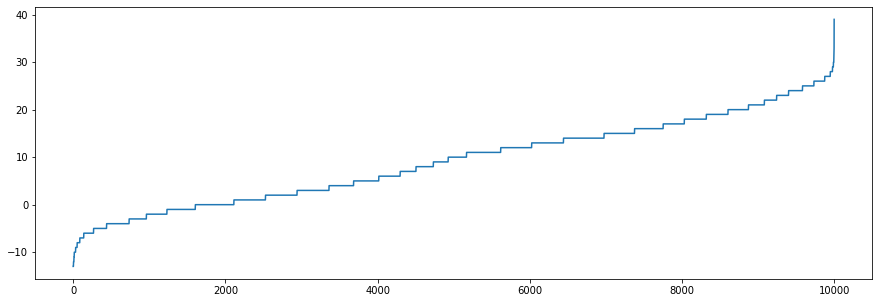

1 irregular errors


array(['Ganze Nuss casew und fleur de sel'], dtype=object)

In [18]:
data2 = data.copy()
colname = "nutrition-score-fr_100g"
possible_vals = possible_val_dict[colname]
limit_vals = limit_val_dict[colname]

## Histogramme global 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("before removing outliers " + colname)
plt.show()    

outliers = extract_irreg_errors_val(colname,possible_vals, data = data)
print("outliers products :",np.array(df.loc[data[colname].isin(outliers), "product_name"]))
# replace outliers by np.nan : 
data2.at[data2[colname].isin(outliers)] = np.nan

## Histogramme : 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("after removing outliers " + colname)
plt.show()

# plot values : 
plt.plot(np.sort(data2[colname]))
plt.show()

## Print problematic variables : 
limit_products = extract_irreg_errors_val(colname, limit_vals, data = data2)
np.array(df.loc[data[colname].isin(limit_products), "product_name"])


In [19]:
df.loc[data[colname].isin(outliers), ["code","product_name",colname] ]

,code,product_name,nutrition-score-fr_100g


In [20]:
limit_products = extract_irreg_errors_val(colname, [-30,-10], data = data)
df.loc[data[colname].isin(limit_products), ["code","product_name",colname] ]
# np.array(df.loc[data[colname].isin(limit_products), "product_name"].index)
df.loc[data.loc[data[colname].isin(limit_products),].index, ["code","product_name",colname]]

df.loc[data.loc[data[colname].isin(limit_products),].index, colname]

43 irregular errors


1397786    -1.0
6794         -5
1428291    22.0
364309     14.0
1367209     2.0
           ... 
531721     14.0
61506       2.0
681277      5.0
1532282    22.0
466395     11.0
Name: nutrition-score-fr_100g, Length: 9969, dtype: object

In [21]:
var = "energy_100g"
nb_bins = min(100, len(np.unique(data[var].dropna().values)))
creators_colors = 
plt.hist(data[var], bins = nb_bins, density=True, edgecolor='none', color = data["creator"])
plt.title(str(var))
print(np.array(data[var].values[:100]))

SyntaxError: invalid syntax (<ipython-input-21-4f23b48175f6>, line 3)

In [ ]:
df.creator.value_counts()[10:]

In [ ]:
df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'count'})

In [ ]:
data.countries.drop_duplicates().values

In [ ]:
## countries VARIABLE TREATMENT (MORE COMPLICATED + TEXT) 
data.countries.drop_duplicates().values[:5]

# 1.3 Outliers 

Let's deal with outliers

# 1.4 Estimate remaining missing values

In [ ]:
import numpy as np
# x = np.array([4,8,12,20,40,60])

x = np.array([2,6,10,16,30,50])
dx = np.array([4,4,4,8,20,20])
n = np.array([40,60,100,160,80,60])
f = n/500
d =f/dx
m = x*f
m.sum()
(np.sqrt(275280/500-(9400/500)**2)-14)*60
0.15*0.9+0.85*0.3
0.9*0.15/0.39
0.9*0.85+0.3*0.15


In [ ]:
from mpl_toolkits import mplot3d
def f(x,y) :
    return x**3 + 3/2*y**2 + 3*x*y + 60

xline = np.linspace(-5, 5, 100)
yline = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(xline, yline)

Z = f(X,Y)
# ax.plot3D(X, Y, Z, 'gray')


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,rstride=1, cmap='viridis', edgecolor='none')
ax.scatter(0, 0, f(0,0), color="red")
ax.scatter(1, -1, f(1,-1), color="black")
plt.show()

In [ ]:

ax.view_init(45,30)
fig

In [ ]:
f(0,0)
# f(1,-1)
